<a href="https://colab.research.google.com/github/lidorsandak/ad_ML_Competition_m5/blob/main/XGBoost_Global_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M5 Forecasting Challenge: XGBoost pipeline

---
--

#### **Set Env**



In [ ]:
# Cell 1: Setup and Data Loading
from google.colab import drive
drive.mount('/content/drive')

# Define path to your data on Google Drive
PROJECT_PATH = '/content/drive/MyDrive/M5_Project/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# First, you might need to install Optuna
!pip install optuna -q

import optuna

# General imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import warnings
import xgboost as xgb
from tqdm import tqdm

from math import ceil

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

##### **Data**

Use preprocessed data from drive

1. Load data
2. Modify to fit model

In [ ]:

# Load data
input_folder = PROJECT_PATH + 'processed_data/'

# Load the dataframes from the Parquet files
df_featured = pd.read_parquet(input_folder + 'df_featured.parquet', engine='pyarrow')
original_df = pd.read_parquet(input_folder + 'original_df.parquet', engine='pyarrow')


print("Processed Data loaded successfully!")


Processed Data loaded successfully!


In [ ]:
def create_all_features(df):
    """
    Creates a comprehensive set of time series features.

    Args:
        df (pd.DataFrame): The input dataframe. Must contain 'date' and 'store_id'.
                           For recursive forecasting, this df will contain both historical
                           and newly predicted rows. The 'revenue' column can contain NaNs
                           for future dates.

    Returns:
        pd.DataFrame: The dataframe with all features added.
    """

    df_featured = df.copy()

    # # --- LOG TRANSFORMATION ---
    df_featured['revenue'] = np.log1p(df_featured['revenue'])

    # --- ENSURE PROPER DATA TYPES & SORTING ---

    df_featured['date'] = pd.to_datetime(df_featured['date'])
    df_featured['store_id'] = df_featured['store_id'].astype('category')
    df_featured = df_featured.sort_values(['store_id', 'date']).reset_index(drop=True)

    # --- 1. TEMPORAL FEATURES ---
    df_featured['year'] = df_featured['date'].dt.year
    df_featured['month'] = df_featured['date'].dt.month
    df_featured['day_of_month'] = df_featured['date'].dt.day
    df_featured['day_of_week'] = df_featured['date'].dt.dayofweek
    df_featured['week_of_year'] = df_featured['date'].dt.isocalendar().week.astype(int)
    df_featured['quarter'] = df_featured['date'].dt.quarter
    df_featured['day_of_year'] = df_featured['date'].dt.dayofyear
    df_featured['is_weekend'] = (df_featured['day_of_week'] >= 5).astype(int)
    df_featured['is_monday'] = (df_featured['day_of_week'] == 0).astype(int)
    df_featured['is_friday'] = (df_featured['day_of_week'] == 4).astype(int)

    # Trend Features (using consistent min_date)
    min_date = df_featured['date'].min()
    df_featured['days_since_start'] = (df_featured['date'] - min_date).dt.days
    df_featured['days_since_start_sq'] = df_featured['days_since_start'] ** 2
    df_featured['days_since_start_cb'] = df_featured['days_since_start'] ** 3
    df_featured['years_since_2011'] = df_featured['year'] - 2011

    # Cyclical Encoding
    df_featured['month_sin'] = np.sin(2 * np.pi * df_featured['month'] / 12)
    df_featured['month_cos'] = np.cos(2 * np.pi * df_featured['month'] / 12)
    df_featured['dow_sin'] = np.sin(2 * np.pi * df_featured['day_of_week'] / 7)
    df_featured['dow_cos'] = np.cos(2 * np.pi * df_featured['day_of_week'] / 7)
    df_featured['doy_sin'] = np.sin(2 * np.pi * df_featured['day_of_year'] / 365)
    df_featured['doy_cos'] = np.cos(2 * np.pi * df_featured['day_of_year'] / 365)

    # --- 2. EVENT & HOLIDAY FEATURES ---
    # Assuming 'event' column is not available for future dates, we create holiday-based ones
    df_featured['is_christmas'] = ((df_featured['date'].dt.month == 12) & (df_featured['date'].dt.day == 25)).astype(int)
    df_featured['is_new_year'] = ((df_featured['date'].dt.month == 1) & (df_featured['date'].dt.day == 1)).astype(int)
    df_featured['is_thanksgiving'] = ((df_featured['date'].dt.month == 11) & (df_featured['date'].dt.day >= 22) & (df_featured['date'].dt.day <= 28) & (df_featured['date'].dt.dayofweek == 3)).astype(int)
    df_featured['is_major_holiday'] = (df_featured['is_christmas'] | df_featured['is_new_year'] | df_featured['is_thanksgiving']).astype(int)

    # Detect store closure dates (data-driven approach: where store_id=0 has near-zero revenue in log scale)
    # In log space, near-zero original revenue (~$60) becomes log1p(60) ≈ 4.09
    closure_threshold_log = 3.0  # Threshold for detecting closures
    store_0_data = df_featured[df_featured['store_id'] == 0][['date', 'revenue']].copy()
    closure_dates = store_0_data[store_0_data['revenue'] < closure_threshold_log]['date'].unique()
    df_featured['is_store_close'] = df_featured['date'].isin(closure_dates).astype(int)

    # For simplicity, we assume 'is_event' is tied to major holidays for future dates
    if 'event' in df_featured.columns:
        df_featured['is_event'] = (df_featured['event'] != 'NoEvent').astype(int)
    else: # If predicting for future, we can't know non-holiday events
        df_featured['is_event'] = df_featured['is_major_holiday']

    # Pre/Post Holiday Effects
    df_featured['days_to_christmas'] = (pd.to_datetime(df_featured['year'].astype(str) + '-12-25') - df_featured['date']).dt.days
    df_featured['is_pre_christmas'] = ((df_featured['days_to_christmas'] > 0) & (df_featured['days_to_christmas'] <= 7)).astype(int)
    df_featured['is_post_christmas'] = ((df_featured['days_to_christmas'] >= -3) & (df_featured['days_to_christmas'] < 0)).astype(int)
    df_featured['is_month_end'] = (df_featured['day_of_month'] >= 28).astype(int)
    df_featured['is_month_start'] = (df_featured['day_of_month'] <= 3).astype(int)

    # Group by store for lag/rolling features
    grouped = df_featured.groupby('store_id')['revenue']

    # --- 3. LAG FEATURES (on log-transformed revenue) ---
    critical_lags = [1, 7, 14, 28]
    for lag in critical_lags:
        df_featured[f'revenue_lag_{lag}'] = grouped.shift(lag)
    df_featured['revenue_weekend_lag_7'] = np.where(df_featured['is_weekend'] == 1, grouped.shift(7), np.nan)
    df_featured['revenue_weekday_lag_7'] = np.where(df_featured['is_weekend'] == 0, grouped.shift(7), np.nan)

    # --- 4. ROLLING WINDOW FEATURES ---
    window_sizes = [7, 14, 28, 46]
    for window in window_sizes:
        rolling_series = grouped.shift(1).rolling(window=window, min_periods=1)
        df_featured[f'revenue_roll_mean_{window}'] = rolling_series.mean()
        df_featured[f'revenue_roll_std_{window}'] = rolling_series.std()
        df_featured[f'revenue_roll_min_{window}'] = rolling_series.min()
        df_featured[f'revenue_roll_max_{window}'] = rolling_series.max()
        df_featured[f'revenue_roll_median_{window}'] = rolling_series.median()

    for window in [7, 28]:
        df_featured[f'revenue_roll_cv_{window}'] = df_featured[f'revenue_roll_std_{window}'] / (df_featured[f'revenue_roll_mean_{window}'] + 1e-8)
        df_featured[f'revenue_roll_sum_{window}'] = grouped.shift(1).rolling(window=window, min_periods=1).sum()

    # --- 5. DIFFERENCE FEATURES ---
    df_featured['revenue_diff_1'] = grouped.diff(1)
    df_featured['revenue_diff_7'] = grouped.diff(7)
    df_featured['revenue_diff_28'] = grouped.diff(28)

    # --- 6. STORE-SPECIFIC FEATURES (Calculated over the whole df) ---
    df_featured['store_revenue_rank'] = df_featured.groupby('store_id')['revenue'].transform('mean').rank(pct=True)
    df_featured['store_volatility'] = df_featured.groupby('store_id')['revenue'].transform(lambda x: x.std() / (x.mean() + 1e-8))

    # Calculate recent and past rolling averages directly across all groups
    recent_growth = (
        df_featured.groupby('store_id')['revenue']
        .shift(1).rolling(90, min_periods=1).mean()
    )
    past_growth = (
        df_featured.groupby('store_id')['revenue']
        .shift(91).rolling(90, min_periods=1).mean()
    )

    # Calculate the growth rate in a single vectorized operation
    df_featured['store_growth_rate'] = (recent_growth - past_growth) / (past_growth + 1e-8)
    # --- 7. INTERACTION FEATURES ---
    for dow in range(7):
        df_featured[f'store_dow_{dow}_interaction'] = ((df_featured['day_of_week'] == dow).astype(int) * df_featured['store_id'].cat.codes)
    df_featured['weekend_month_interaction'] = df_featured['is_weekend'] * df_featured['month']
    df_featured['event_weekend_interaction'] = df_featured['is_event'] * df_featured['is_weekend']
    df_featured['trend_store_interaction'] = df_featured['days_since_start'] * df_featured['store_id'].cat.codes

    # --- 8. EXPANDING & COMPARATIVE FEATURES ---
    expanding_grouped = df_featured.groupby('store_id')['revenue'].shift(1).expanding(min_periods=1)
    df_featured['revenue_expanding_mean'] = expanding_grouped.mean().reset_index(level=0, drop=True)
    df_featured['revenue_expanding_std'] = expanding_grouped.std().reset_index(level=0, drop=True)
    df_featured['revenue_vs_store_avg'] = df_featured['revenue_lag_1'] - df_featured['revenue_expanding_mean']
    df_featured['revenue_vs_roll_mean_28'] = df_featured['revenue_lag_1'] - df_featured['revenue_roll_mean_28']
    df_featured['revenue_zscore_28'] = (df_featured['revenue_lag_1'] - df_featured['revenue_roll_mean_28']) / (df_featured['revenue_roll_std_28'] + 1e-8)

    return df_featured

In [ ]:
df_featured.columns

Index(['store_id', 'store_name', 'date', 'revenue', 'event', 'year', 'month',
       'day_of_month', 'day_of_week', 'week_of_year', 'quarter', 'day_of_year',
       'is_weekend', 'is_monday', 'is_friday', 'days_since_start',
       'days_since_start_sq', 'days_since_start_cb', 'years_since_2011',
       'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos',
       'is_christmas', 'is_new_year', 'is_thanksgiving', 'is_major_holiday',
       'is_store_close', 'is_event', 'days_to_christmas', 'is_pre_christmas',
       'is_post_christmas', 'is_month_end', 'is_month_start', 'revenue_lag_1',
       'revenue_lag_7', 'revenue_lag_14', 'revenue_lag_28',
       'revenue_weekend_lag_7', 'revenue_weekday_lag_7', 'revenue_roll_mean_7',
       'revenue_roll_std_7', 'revenue_roll_min_7', 'revenue_roll_max_7',
       'revenue_roll_median_7', 'revenue_roll_mean_14', 'revenue_roll_std_14',
       'revenue_roll_min_14', 'revenue_roll_max_14', 'revenue_roll_median_14',
       'revenue_roll

**Submission data preprocessing**

In [ ]:
sample_submission = pd.read_csv(PROJECT_PATH + 'forecast_submission.csv')
submission_ids = sample_submission['id'].str.split('_', expand=True)
submission_ids.columns = ['store_id', 'date']
submission_ids['store_id'] = submission_ids['store_id'].astype('category')
submission_dates = pd.to_datetime(submission_ids['date'], format='%Y%m%d')
# The forecast horizon H is the number of unique dates in the submission file
H = submission_dates.nunique()
print(f"The Forecast Horizon (H) is: {H} days.")

The Forecast Horizon (H) is: 92 days.


In [ ]:
sample_submission

,id,prediction
0,0_20151001,0
1,0_20151002,0
2,0_20151003,0
3,0_20151004,0
4,0_20151005,0
...,...,...
1007,10_20151227,0
1008,10_20151228,0
1009,10_20151229,0
1010,10_20151230,0


**Split to train/validation**

In [ ]:
# --- train and validation sets from the FEATURED data ---
last_train_date_featured = df_featured['date'].max() - pd.to_timedelta(H, unit='D')
validation_start_date_featured = last_train_date_featured + pd.to_timedelta(1, unit='D')

train_df = df_featured[df_featured['date'] <= last_train_date_featured]
val_df = df_featured[df_featured['date'] >= validation_start_date_featured]

# --- Define our features (X) and target (y) ---
TARGET = 'revenue'

FEATURES = [col for col in train_df.columns if col not in [TARGET, 'store_name', 'date', 'weekday', 'event']]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_val = val_df[FEATURES]
y_val = val_df[TARGET]

print("Training data shape (X, y):", X_train.shape, y_train.shape)
print("Validation data shape (X, y):", X_val.shape, y_val.shape)

display(X_train.head())
display(X_train.columns)

Training data shape (X, y): (17446, 83) (17446,)
Validation data shape (X, y): (1012, 83) (1012,)


,store_id,year,month,day_of_month,day_of_week,week_of_year,quarter,day_of_year,is_weekend,is_monday,...,store_dow_5_interaction,store_dow_6_interaction,weekend_month_interaction,event_weekend_interaction,trend_store_interaction,revenue_expanding_mean,revenue_expanding_std,revenue_vs_store_avg,revenue_vs_roll_mean_28,revenue_zscore_28
28,0,2011,2,26,5,8,1,57,1,0,...,0,0,2,0,0,12.036119,0.190489,-0.088538,-0.088538,-0.464793
29,0,2011,2,27,6,8,1,58,1,0,...,0,0,2,0,0,12.042764,0.190448,0.186047,0.192609,1.010673
30,0,2011,2,28,0,9,1,59,0,1,...,0,0,0,0,0,12.047978,0.189302,0.151216,0.162776,0.853288
31,0,2011,3,1,1,9,1,60,0,0,...,0,0,0,0,0,12.043144,0.188057,-0.145040,-0.138982,-0.730613
32,0,2011,3,2,2,9,1,61,0,0,...,0,0,0,0,0,12.040541,0.185584,-0.080679,-0.078255,-0.412501


Index(['store_id', 'year', 'month', 'day_of_month', 'day_of_week',
       'week_of_year', 'quarter', 'day_of_year', 'is_weekend', 'is_monday',
       'is_friday', 'days_since_start', 'days_since_start_sq',
       'days_since_start_cb', 'years_since_2011', 'month_sin', 'month_cos',
       'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos', 'is_christmas',
       'is_new_year', 'is_thanksgiving', 'is_major_holiday', 'is_store_close',
       'is_event', 'days_to_christmas', 'is_pre_christmas',
       'is_post_christmas', 'is_month_end', 'is_month_start', 'revenue_lag_1',
       'revenue_lag_7', 'revenue_lag_14', 'revenue_lag_28',
       'revenue_weekend_lag_7', 'revenue_weekday_lag_7', 'revenue_roll_mean_7',
       'revenue_roll_std_7', 'revenue_roll_min_7', 'revenue_roll_max_7',
       'revenue_roll_median_7', 'revenue_roll_mean_14', 'revenue_roll_std_14',
       'revenue_roll_min_14', 'revenue_roll_max_14', 'revenue_roll_median_14',
       'revenue_roll_mean_28', 'revenue_roll_std_28', 'revenue

# Modeling

**Strategic Choice:**

❌ Option A: Forecast all 11 independently

- Pros: Simple, allows customization per store
- Cons: Forecasts won't reconcile (sum of stores ≠ total)

✅ Option B: Bottom-Up Reconciliation (RECOMMENDED)

- Forecast stores 1-10 individually
- Sum them to get store 0
- Pros: Guaranteed consistency, leverages store-specific patterns
- Cons: Errors accumulate


✅ Option C: Top-Down Reconciliation

- Forecast store 0 (total)
- Allocate proportionally to stores 1-10
- Pros: Total is most stable (less variance)
- Cons: Loses store-specific dynamics

🎯 Hybrid Approach

- Forecast stores 1-10 with separate models
- Forecast store 0 independently
- Use hierarchical reconciliation (MinTrace algorithm) to enforce consistency
- This gives best of both worlds!



#### LightGBM

| Model | Pros for Your Data | Cons for Your Data | Overall Score |
|-------|-------------------|-------------------|---------------|
| **ARIMA/SARIMA** | ✓ Handles 7-day seasonality<br>✓ Statistical rigor | ✗ Struggles with holidays<br>✗ Can't use 88 features<br>✗ Separate model per store needed | 4/10 |
| **Prophet** | ✓ Excellent holiday handling<br>✓ Automatic weekly seasonality<br>✓ Handles trend changes | ✗ Can't use lag features<br>✗ Limited to temporal regressors<br>✗ No store interactions | 6/10 |
| **XGBoost** | ✓ Uses all 88 features<br>✓ Handles non-linearity<br>✓ Robust to outliers<br>✓ Feature importance | ✗ Needs recursive forecasting logic<br>✗ No native uncertainty | **8/10** ⭐ |
| **LightGBM** | ✓ Same as XGBoost<br>✓ Faster training<br>✓ Better with categorical features | ✗ Same cons as XGBoost | **8/10** ⭐ |
| **LSTM/RNN** | ✓ Learns temporal patterns<br>✓ Handles sequences | ✗ Needs much more data<br>✗ Hard to interpret<br>✗ Overkill for this problem | 5/10 |
| **Linear Regression** | ✓ Simple, interpretable | ✗ Can't capture non-linear trend<br>✗ Poor with holidays | 3/10 |
| **Ensemble (Hybrid)** | ✓ Combines strengths<br>✓ More robust | ✗ More complex<br>✗ Harder to maintain | **9/10** 🏆 |

┌─────────────────────────────────────────────────────────┐
│                    STAGE 1: BASE FORECASTS              │
├─────────────────────────────────────────────────────────┤
│                                                         │
│  For Each Store (1-10):                                │
│  ┌────────────────────────────────────────────┐        │
│  │  Model A: XGBoost (70% weight)             │        │
│  │  - Uses all 88 features                    │        │
│  │  - Recursive 92-day forecasting            │        │
│  │  - Separate model per store                │        │
│  └────────────────────────────────────────────┘        │
│                        +                                │
│  ┌────────────────────────────────────────────┐        │
│  │  Model B: Prophet (30% weight)             │        │
│  │  - Handles trend + seasonality             │        │
│  │  - Holiday calendar (Christmas, etc.)      │        │
│  │  - Fallback for extreme dates              │        │
│  └────────────────────────────────────────────┘        │
│                        ↓                                │
│           Weighted Average = Base Forecast              │
│                                                         │
├─────────────────────────────────────────────────────────┤
│                   STAGE 2: RECONCILIATION               │
├─────────────────────────────────────────────────────────┤
│                                                         │
│  1. Sum base forecasts: store_0_base = Σ(stores 1-10)  │
│  2. Forecast store_0 independently with XGBoost        │
│  3. Apply MinTrace reconciliation:                     │
│     - Adjust all forecasts to maintain hierarchy       │
│     - Minimize variance in adjustments                 │
│  4. Final forecasts respect: store_0 = Σ(stores 1-10)  │
│                                                         │
└─────────────────────────────────────────────────────────┘

### Model - XGBoost


Bootom up

In [ ]:
df_featured.columns

Index(['store_id', 'store_name', 'date', 'revenue', 'event', 'year', 'month',
       'day_of_month', 'day_of_week', 'week_of_year', 'quarter', 'day_of_year',
       'is_weekend', 'is_monday', 'is_friday', 'days_since_start',
       'days_since_start_sq', 'days_since_start_cb', 'years_since_2011',
       'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'doy_sin', 'doy_cos',
       'is_christmas', 'is_new_year', 'is_thanksgiving', 'is_major_holiday',
       'is_store_close', 'is_event', 'days_to_christmas', 'is_pre_christmas',
       'is_post_christmas', 'is_month_end', 'is_month_start', 'revenue_lag_1',
       'revenue_lag_7', 'revenue_lag_14', 'revenue_lag_28',
       'revenue_weekend_lag_7', 'revenue_weekday_lag_7', 'revenue_roll_mean_7',
       'revenue_roll_std_7', 'revenue_roll_min_7', 'revenue_roll_max_7',
       'revenue_roll_median_7', 'revenue_roll_mean_14', 'revenue_roll_std_14',
       'revenue_roll_min_14', 'revenue_roll_max_14', 'revenue_roll_median_14',
       'revenue_roll

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:

# --- 1. Identify Categorical Features ---
categorical_features = [
    'store_id',
    'year',
    'month',
    'day_of_month',
    'day_of_week',
    'week_of_year',
    'quarter',
    'store_revenue_rank',
    'is_weekend',
    'is_monday',
    'is_friday',
    'is_event',
    'is_christmas',
    'is_new_year',
    'is_thanksgiving',
    'is_major_holiday',
    'is_pre_christmas',
    'is_post_christmas',
    'is_month_end',
    'is_month_start',
    'weekend_month_interaction', # Add other interactions if they are label-based
    'event_weekend_interaction',
]

In [ ]:

# Define features (exclude identifiers and target)
feature_cols = [c for c in df_featured.columns if c not in
                ['revenue', 'store_name', 'date', 'event', 'store_id']]

# --- 2. Initialize and Train the Model ---

# Store individual models
xgb_models = {}

# Train a separate model for each store
for store_id in range(1, 11):  # Stores 1-10
    print(f"\n Training XGBoost for Store {store_id}...")

    # Filter data for this store
    train_store = train_df[train_df['store_id'] == store_id]

    X_train = train_store[feature_cols]
    y_train = train_store['revenue']

    # XGBoost model with optimal hyperparameters
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50  # ✅ MOVED HERE (XGBoost 2.0+)
    )

    # FIT WITHOUT early_stopping_rounds parameter
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train)],  # Evaluation set for early stopping
        verbose=False
    )

    xgb_models[store_id] = model

    # Get best iteration info
    print(f" Best iteration: {model.best_iteration}")
    print(f" Best score: {model.best_score:.4f}")


 Training XGBoost for Store 1...
 Best iteration: 221
 Best score: 0.0345

 Training XGBoost for Store 2...
 Best iteration: 362
 Best score: 0.0369

 Training XGBoost for Store 3...
 Best iteration: 437
 Best score: 0.0488

 Training XGBoost for Store 4...
 Best iteration: 257
 Best score: 0.0337

 Training XGBoost for Store 5...
 Best iteration: 496
 Best score: 0.0375

 Training XGBoost for Store 6...
 Best iteration: 495
 Best score: 0.0497

 Training XGBoost for Store 7...
 Best iteration: 460
 Best score: 0.0373

 Training XGBoost for Store 8...
 Best iteration: 493
 Best score: 0.0438

 Training XGBoost for Store 9...
 Best iteration: 480
 Best score: 0.0522

 Training XGBoost for Store 10...
 Best iteration: 494
 Best score: 0.0417


In [ ]:

from sklearn.metrics import mean_squared_error

# --- 1. Generate Predictions on the Validation Set ---

all_store_predictions = []

for store_id in range(1, 11):
    print(f"Predicting for Store {store_id}...")
    val_store_df = val_df[val_df['store_id'] == store_id].copy()
    X_val_store = val_store_df[feature_cols]
    model = xgb_models[store_id]
    predictions = model.predict(X_val_store)
    y_val_actual = np.expm1(y_val)
    y_val_pred = np.expm1(predictions)
    val_store_df['prediction'] = y_val_pred

    # Append the results (actuals and predictions) to our master list
    all_store_predictions.append(val_store_df[['date', 'store_id', 'revenue', 'prediction']])

# Concatenate all individual store predictions into a single DataFrame
val_results_df = pd.concat(all_store_predictions, ignore_index=True)

print("\nPrediction generation complete.")

# --- 2. Evaluate Forecast Performance ---

print("\n--- Evaluating Forecast Performance (RMSE) ---")

# --- 2a. Individual Store-Level Evaluation ---
store_level_rmse = {}
print("\nIndividual Store RMSEs:")
for store_id in range(1, 11):
    # Filter results for the current store
    store_results = val_results_df[val_results_df['store_id'] == store_id]

    # Calculate RMSE between the true revenue and the prediction
    rmse = np.sqrt(mean_squared_error(store_results['revenue'], store_results['prediction']))

    store_level_rmse[store_id] = rmse
    print(f"  Store {store_id}: ${rmse:,.2f}")

# --- 2b. Overall Individual-Level Evaluation ---
# This calculates the RMSE across all individual predictions before any aggregation
overall_individual_rmse = np.sqrt(mean_squared_error(val_results_df['revenue'], val_results_df['prediction']))
print(f"\nOverall RMSE (across all individual store predictions): ${overall_individual_rmse:,.2f}")


# --- 2c. Aggregate (Total Revenue) Level Evaluation ---
# To evaluate the total combined forecast, we sum up actuals and predictions by date
aggregated_results = val_results_df.groupby('date')[['revenue', 'prediction']].sum()

# Calculate RMSE on the aggregated (total) daily revenue
aggregate_rmse = np.sqrt(mean_squared_error(aggregated_results['revenue'], aggregated_results['prediction']))
print(f"\nAggregate RMSE (for total combined daily revenue): ${aggregate_rmse:,.2f}")

# --- 3. (Optional) Display a Final Summary DataFrame ---
rmse_summary_df = pd.DataFrame(list(store_level_rmse.items()), columns=['Store ID', 'RMSE'])
rmse_summary_df = rmse_summary_df.set_index('Store ID')
rmse_summary_df.loc['Overall Individual Avg'] = overall_individual_rmse
rmse_summary_df.loc['Total Aggregated'] = aggregate_rmse
rmse_summary_df['RMSE'] = rmse_summary_df['RMSE'].map('${:,.2f}'.format)

print("\n\n--- RMSE Evaluation Summary ---")
print(rmse_summary_df)


Predicting for Store 1...
Predicting for Store 2...
Predicting for Store 3...
Predicting for Store 4...
Predicting for Store 5...
Predicting for Store 6...
Predicting for Store 7...
Predicting for Store 8...
Predicting for Store 9...
Predicting for Store 10...

Prediction generation complete.

--- Evaluating Forecast Performance (RMSE) ---

Individual Store RMSEs:
  Store 1: $35,221.99
  Store 2: $26,833.34
  Store 3: $49,471.87
  Store 4: $19,022.59
  Store 5: $24,070.47
  Store 6: $29,716.02
  Store 7: $29,847.52
  Store 8: $25,340.01
  Store 9: $29,147.58
  Store 10: $22,436.44

Overall RMSE (across all individual store predictions): $30,196.58

Aggregate RMSE (for total combined daily revenue): $290,425.95


--- RMSE Evaluation Summary ---
                               RMSE
Store ID                           
1                        $35,221.99
2                        $26,833.34
3                        $49,471.87
4                        $19,022.59
5                        $24,0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:


# =============================================================================
# CONFIGURATION
# =============================================================================


# Stores to evaluate
STORE_IDS = list(range(1, 11))  # Stores 1-10

# Feature columns (must match training)
feature_cols = [c for c in df_featured.columns if c not in
                ['revenue', 'store_name', 'date', 'event', 'store_id']]

print(f"Number of Stores: {len(STORE_IDS)}")
print(f"Number of Features: {len(feature_cols)}\n")

# =============================================================================
# LEVEL 1: ONE-STEP-AHEAD ACCURACY (Overfitting Check)
# =============================================================================

print("\n" + "="*70)
print("📊 LEVEL 1: ONE-STEP-AHEAD ACCURACY")
print("="*70)

one_step_results = []

for store_id in STORE_IDS:
    # Get train and validation data for this store
    train_store = train_df[train_df['store_id'] == store_id]
    val_store = val_df[val_df['store_id'] == store_id]

    X_train = train_store[feature_cols]
    y_train = train_store['revenue']
    X_val = val_store[feature_cols]
    y_val = val_store['revenue']

    # Get model
    model = xgb_models[store_id]

    # Predictions (log scale)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert to original scale
    y_train_actual_orig = np.expm1(y_train)
    y_train_pred_orig = np.expm1(y_train_pred)
    y_val_actual_orig = np.expm1(y_val)
    y_val_pred_orig = np.expm1(y_val_pred)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual_orig, y_train_pred_orig))
    val_rmse = np.sqrt(mean_squared_error(y_val_actual_orig, y_val_pred_orig))
    train_mae = mean_absolute_error(y_train_actual_orig, y_train_pred_orig)
    val_mae = mean_absolute_error(y_val_actual_orig, y_val_pred_orig)

    # MAPE
    train_mape = np.mean(np.abs((y_train_actual_orig - y_train_pred_orig) / y_train_actual_orig)) * 100
    val_mape = np.mean(np.abs((y_val_actual_orig - y_val_pred_orig) / y_val_actual_orig)) * 100

    # Overfitting ratio (val_error / train_error)
    overfit_ratio = val_rmse / train_rmse

    one_step_results.append({
        'store_id': store_id,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_mape': train_mape,
        'val_mape': val_mape,
        'overfit_ratio': overfit_ratio
    })

    print(f"\n🏪 Store {store_id}:")
    print(f"  Train RMSE: {train_rmse:,.2f}  |  Val RMSE: {val_rmse:,.2f}")
    print(f"  Train MAE:  {train_mae:,.2f}  |  Val MAE:  {val_mae:,.2f}")
    print(f"  Train MAPE: {train_mape:.2f}%     |  Val MAPE: {val_mape:.2f}%")
    print(f"  Overfitting Ratio: {overfit_ratio:.2f} {'✅' if overfit_ratio < 1.3 else '⚠️ HIGH'}")

# Summary
one_step_df = pd.DataFrame(one_step_results)
print("\n" + "-"*70)
print("📈 SUMMARY - One-Step-Ahead Performance:")
print("-"*70)
print(f"Average Validation RMSE: {one_step_df['val_rmse'].mean():,.2f}")
print(f"Average Validation MAPE: {one_step_df['val_mape'].mean():.2f}%")
print(f"Average Overfitting Ratio: {one_step_df['overfit_ratio'].mean():.2f}")
print(f"Max Overfitting Ratio: {one_step_df['overfit_ratio'].max():.2f} (Store {one_step_df.loc[one_step_df['overfit_ratio'].idxmax(), 'store_id']})")

# Overfitting check
if one_step_df['overfit_ratio'].mean() > 1.3:
    print("\n⚠️  WARNING: Possible overfitting detected (ratio > 1.3)")
    print("   Consider: reducing max_depth, increasing reg_alpha/reg_lambda")
else:
    print("\n✅ No significant overfitting detected")


Number of Stores: 10
Number of Features: 82


📊 LEVEL 1: ONE-STEP-AHEAD ACCURACY

🏪 Store 1:
  Train RMSE: 950.91  |  Val RMSE: 2,160.45
  Train MAE:  581.28  |  Val MAE:  1,375.42
  Train MAPE: inf%     |  Val MAPE: 3.38%
  Overfitting Ratio: 2.27 ⚠️ HIGH

🏪 Store 2:
  Train RMSE: 674.05  |  Val RMSE: 6,526.23
  Train MAE:  409.03  |  Val MAE:  4,686.64
  Train MAPE: 2.04%     |  Val MAPE: 12.68%
  Overfitting Ratio: 9.68 ⚠️ HIGH

🏪 Store 3:
  Train RMSE: 1,213.10  |  Val RMSE: 2,931.98
  Train MAE:  740.31  |  Val MAE:  1,876.99
  Train MAPE: inf%     |  Val MAPE: 3.32%
  Overfitting Ratio: 2.42 ⚠️ HIGH

🏪 Store 4:
  Train RMSE: 458.17  |  Val RMSE: 929.94
  Train MAE:  294.39  |  Val MAE:  616.60
  Train MAPE: inf%     |  Val MAPE: 2.96%
  Overfitting Ratio: 2.03 ⚠️ HIGH

🏪 Store 5:
  Train RMSE: 657.80  |  Val RMSE: 1,966.41
  Train MAE:  385.60  |  Val MAE:  954.13
  Train MAPE: inf%     |  Val MAPE: 3.59%
  Overfitting Ratio: 2.99 ⚠️ HIGH

🏪 Store 6:
  Train RMSE: 936.38  |  Val 



🔮 LEVEL 2: RECURSIVE 92-DAY FORECASTING

 Forecasting Store 1 (92 days ahead)...
  ✅ Overall RMSE: $8,521.52
  ✅ Overall MAPE: 15.52%
  Performance by horizon:
    1-7 days       : RMSE $8,829.01  |  MAPE 18.33%
    8-30 days      : RMSE $6,504.14  |  MAPE 12.17%
    31-60 days     : RMSE $9,859.19  |  MAPE 17.74%
    61-92 days     : RMSE $8,377.68  |  MAPE 15.24%

 Forecasting Store 2 (92 days ahead)...
  ✅ Overall RMSE: $13,323.09
  ✅ Overall MAPE: 31.26%
  Performance by horizon:
    1-7 days       : RMSE $8,832.63  |  MAPE 22.97%
    8-30 days      : RMSE $10,674.69  |  MAPE 24.85%
    31-60 days     : RMSE $13,978.91  |  MAPE 33.75%
    61-92 days     : RMSE $15,105.05  |  MAPE 35.35%

 Forecasting Store 3 (92 days ahead)...
  ✅ Overall RMSE: $10,390.05
  ✅ Overall MAPE: 14.31%
  Performance by horizon:
    1-7 days       : RMSE $9,619.92  |  MAPE 13.55%
    8-30 days      : RMSE $8,642.59  |  MAPE 12.54%
    31-60 days     : RMSE $12,092.03  |  MAPE 16.22%
    61-92 days     :

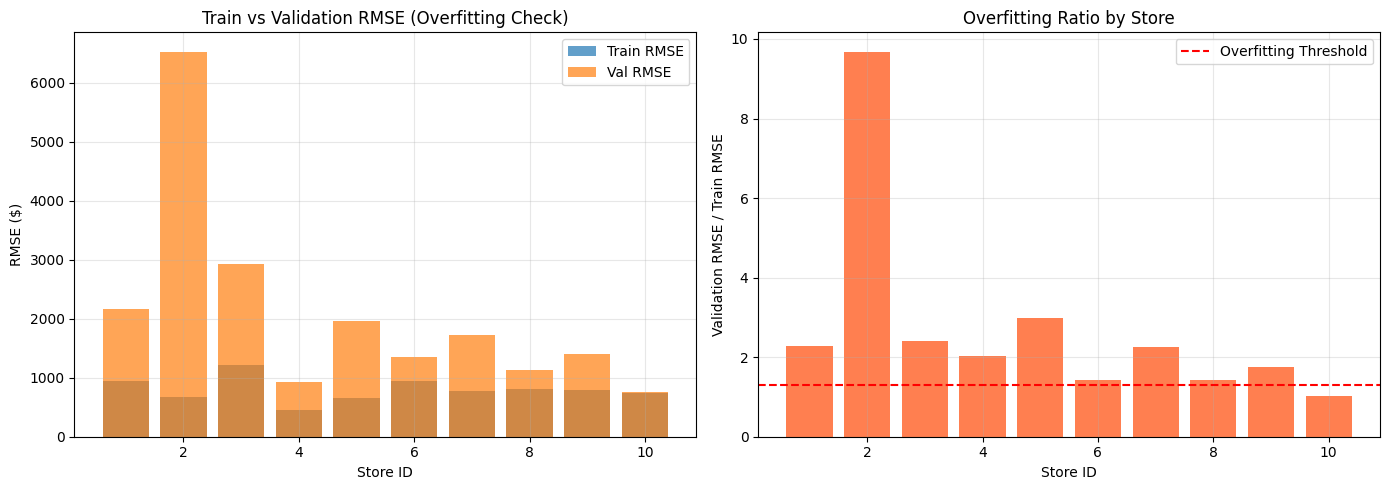

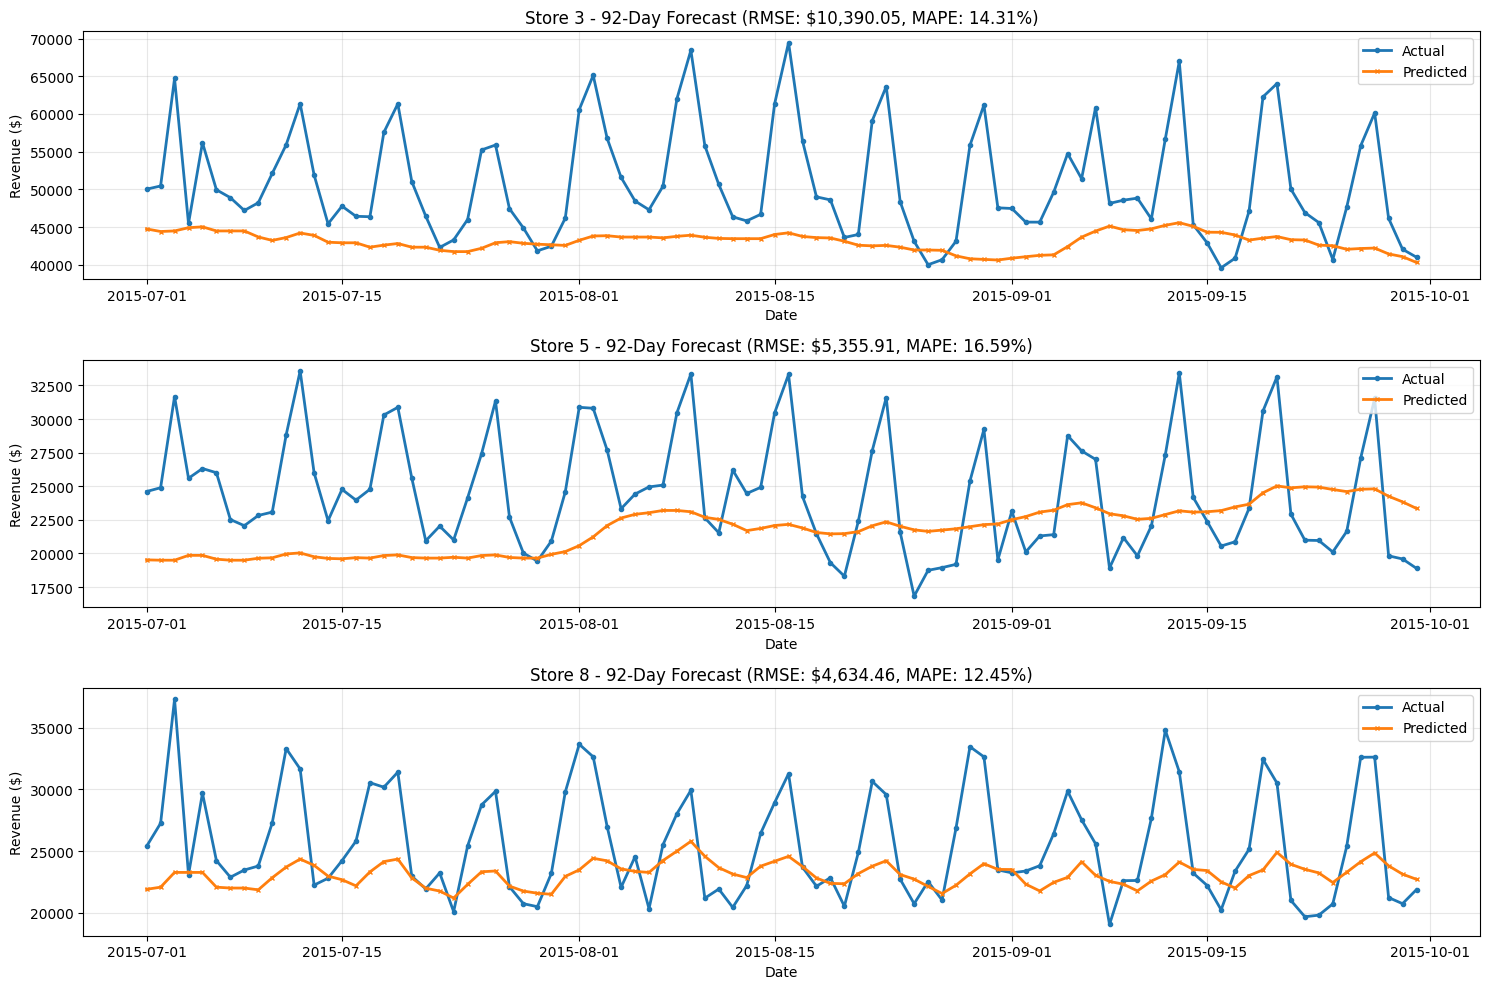

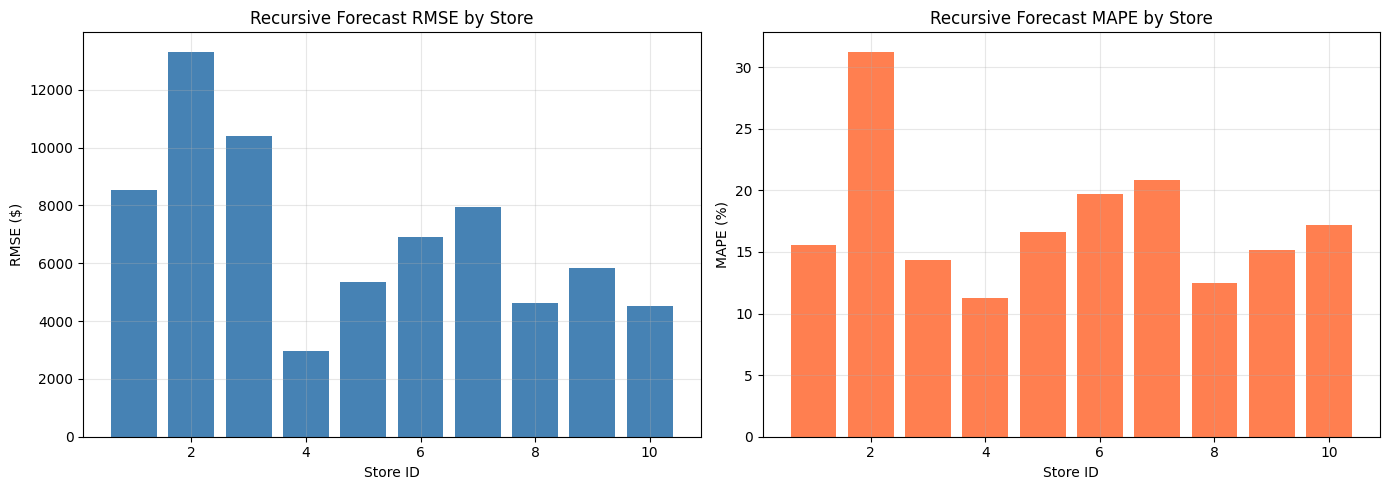



🎯 FINAL EVALUATION VERDICT

1. Overfitting Assessment: ⚠️  WARNING - Overfitting detected
   Average Overfitting Ratio: 2.73

2. Overall Performance: ⚠️  FAIR - Room for improvement
   Average MAPE: 17.43%
   Average RMSE: $7,038.16

3. Long-Term Stability: ✅ EXCELLENT - Stable long-term forecasts
   Early forecast RMSE (days 1-7): $7,850.05
   Late forecast RMSE (days 61-92): $6,819.47
   Degradation Ratio: 0.87x

⚠️  MODEL NEEDS IMPROVEMENT - Review recommendations above


In [ ]:
FORECAST_HORIZON=92
# =============================================================================
# LEVEL 2: RECURSIVE MULTI-STEP FORECASTING (The Real Test!)
# =============================================================================

print("\n\n" + "="*70)
print("🔮 LEVEL 2: RECURSIVE 92-DAY FORECASTING")
print("="*70)

def recursive_forecast_evaluation(model, last_train_row, feature_cols, horizon, future_dates):
    """
    Perform recursive forecasting and return predictions

    Returns:
    --------
    predictions_log : array of predictions in log scale
    """
    predictions_log = []

    # Start with last known data
    current_row = last_train_row.copy()

    for step in range(horizon):
        # Current date for this prediction
        current_date = future_dates.iloc[step]

        # Update temporal features
        current_row['day_of_week'] = current_date.dayofweek
        current_row['day_of_month'] = current_date.day
        current_row['month'] = current_date.month
        current_row['year'] = current_date.year
        current_row['quarter'] = current_date.quarter
        current_row['day_of_year'] = current_date.dayofyear
        current_row['week_of_year'] = current_date.isocalendar()[1]

        # Update binary indicators
        current_row['is_weekend'] = int(current_date.dayofweek >= 5)
        current_row['is_monday'] = int(current_date.dayofweek == 0)
        current_row['is_friday'] = int(current_date.dayofweek == 4)

        # Update trend features
        min_date = df_featured['date'].min()
        current_row['days_since_start'] = (current_date - min_date).days
        current_row['days_since_start_sq'] = current_row['days_since_start'] ** 2
        current_row['days_since_start_cb'] = current_row['days_since_start'] ** 3
        current_row['years_since_2011'] = current_date.year - 2011

        # Update cyclical features
        current_row['month_sin'] = np.sin(2 * np.pi * current_date.month / 12)
        current_row['month_cos'] = np.cos(2 * np.pi * current_date.month / 12)
        current_row['dow_sin'] = np.sin(2 * np.pi * current_date.dayofweek / 7)
        current_row['dow_cos'] = np.cos(2 * np.pi * current_date.dayofweek / 7)
        current_row['doy_sin'] = np.sin(2 * np.pi * current_date.dayofyear / 365)
        current_row['doy_cos'] = np.cos(2 * np.pi * current_date.dayofyear / 365)

        # Update holiday features
        current_row['is_christmas'] = int((current_date.month == 12) and (current_date.day == 25))
        current_row['is_new_year'] = int((current_date.month == 1) and (current_date.day == 1))
        current_row['is_thanksgiving'] = int(
            (current_date.month == 11) and
            (current_date.day >= 22) and
            (current_date.day <= 28) and
            (current_date.dayofweek == 3)
        )
        current_row['is_major_holiday'] = int(
            current_row['is_christmas'] or
            current_row['is_new_year'] or
            current_row['is_thanksgiving']
        )

        # Days to Christmas
        christmas_this_year = pd.Timestamp(f'{current_date.year}-12-25')
        current_row['days_to_christmas'] = (christmas_this_year - current_date).days
        current_row['is_pre_christmas'] = int((current_row['days_to_christmas'] > 0) and
                                               (current_row['days_to_christmas'] <= 7))
        current_row['is_post_christmas'] = int((current_row['days_to_christmas'] >= -3) and
                                                (current_row['days_to_christmas'] < 0))

        # Month-end effects
        current_row['is_month_end'] = int(current_date.day >= 28)
        current_row['is_month_start'] = int(current_date.day <= 3)

        # Predict
        X_pred = current_row[feature_cols].values.reshape(1, -1)
        pred_log = model.predict(X_pred)[0]
        predictions_log.append(pred_log)

        # Update lag features with prediction
        # Shift existing lags
        if 'revenue_lag_28' in feature_cols:
            if step >= 28:
                current_row['revenue_lag_28'] = predictions_log[step - 28]

        if 'revenue_lag_14' in feature_cols:
            if step >= 14:
                current_row['revenue_lag_14'] = predictions_log[step - 14]

        if 'revenue_lag_7' in feature_cols:
            if step >= 7:
                current_row['revenue_lag_7'] = predictions_log[step - 7]

        if 'revenue_lag_1' in feature_cols:
            current_row['revenue_lag_1'] = pred_log

        # Update rolling features
        if step >= 7:
            recent_7 = predictions_log[max(0, step-7):step+1]
            current_row['revenue_roll_mean_7'] = np.mean(recent_7)
            current_row['revenue_roll_std_7'] = np.std(recent_7) if len(recent_7) > 1 else 0
            current_row['revenue_roll_min_7'] = np.min(recent_7)
            current_row['revenue_roll_max_7'] = np.max(recent_7)
            current_row['revenue_roll_median_7'] = np.median(recent_7)
            current_row['revenue_roll_sum_7'] = np.sum(recent_7)
            current_row['revenue_roll_cv_7'] = (current_row['revenue_roll_std_7'] /
                                                 (current_row['revenue_roll_mean_7'] + 1e-8))

        if step >= 14:
            recent_14 = predictions_log[max(0, step-14):step+1]
            current_row['revenue_roll_mean_14'] = np.mean(recent_14)
            current_row['revenue_roll_std_14'] = np.std(recent_14) if len(recent_14) > 1 else 0
            current_row['revenue_roll_min_14'] = np.min(recent_14)
            current_row['revenue_roll_max_14'] = np.max(recent_14)
            current_row['revenue_roll_median_14'] = np.median(recent_14)

        if step >= 28:
            recent_28 = predictions_log[max(0, step-28):step+1]
            current_row['revenue_roll_mean_28'] = np.mean(recent_28)
            current_row['revenue_roll_std_28'] = np.std(recent_28) if len(recent_28) > 1 else 0
            current_row['revenue_roll_min_28'] = np.min(recent_28)
            current_row['revenue_roll_max_28'] = np.max(recent_28)
            current_row['revenue_roll_median_28'] = np.median(recent_28)
            current_row['revenue_roll_sum_28'] = np.sum(recent_28)
            current_row['revenue_roll_cv_28'] = (current_row['revenue_roll_std_28'] /
                                                  (current_row['revenue_roll_mean_28'] + 1e-8))

        if step >= 46:
            recent_46 = predictions_log[max(0, step-46):step+1]
            current_row['revenue_roll_mean_46'] = np.mean(recent_46)
            current_row['revenue_roll_std_46'] = np.std(recent_46) if len(recent_46) > 1 else 0
            current_row['revenue_roll_min_46'] = np.min(recent_46)
            current_row['revenue_roll_max_46'] = np.max(recent_46)
            current_row['revenue_roll_median_46'] = np.median(recent_46)

        # Update difference features
        if step >= 1:
            current_row['revenue_diff_1'] = pred_log - predictions_log[step - 1]
        if step >= 7:
            current_row['revenue_diff_7'] = pred_log - predictions_log[step - 7]
        if step >= 28:
            current_row['revenue_diff_28'] = pred_log - predictions_log[step - 28]

        # Update expanding window features (use all predictions so far)
        all_preds_so_far = predictions_log[:step+1]
        current_row['revenue_expanding_mean'] = np.mean(all_preds_so_far)
        current_row['revenue_expanding_std'] = np.std(all_preds_so_far) if len(all_preds_so_far) > 1 else 0

        # Update comparative features
        current_row['revenue_vs_store_avg'] = pred_log - current_row['revenue_expanding_mean']
        if step >= 28:
            current_row['revenue_vs_roll_mean_28'] = pred_log - current_row['revenue_roll_mean_28']
            current_row['revenue_zscore_28'] = ((pred_log - current_row['revenue_roll_mean_28']) /
                                                 (current_row['revenue_roll_std_28'] + 1e-8))

    return np.array(predictions_log)


# Run recursive forecasting for each store
recursive_results = []

for store_id in STORE_IDS:
    print(f"\n Forecasting Store {store_id} (92 days ahead)...")

    # Get last row from training set
    last_train_row = train_df[train_df['store_id'] == store_id].iloc[-1:].copy()

    # Get actual validation data
    val_store = val_df[val_df['store_id'] == store_id].iloc[:FORECAST_HORIZON]
    actual_log = val_store['revenue'].values
    actual_orig = np.expm1(actual_log)
    future_dates = val_store['date'].reset_index(drop=True)

    # Get model
    model = xgb_models[store_id]

    # Recursive forecast
    pred_log = recursive_forecast_evaluation(
        model,
        last_train_row.iloc[0],
        feature_cols,
        min(FORECAST_HORIZON, len(val_store)),
        future_dates
    )
    pred_orig = np.expm1(pred_log)

    # Calculate metrics overall
    overall_rmse = np.sqrt(mean_squared_error(actual_orig, pred_orig))
    overall_mae = mean_absolute_error(actual_orig, pred_orig)
    overall_mape = np.mean(np.abs((actual_orig - pred_orig) / actual_orig)) * 100

    # Calculate metrics by horizon
    horizons = {
        '1-7 days': (0, 7),
        '8-30 days': (7, 30),
        '31-60 days': (30, 60),
        '61-92 days': (60, min(92, len(pred_orig)))
    }

    horizon_metrics = {}
    for period, (start, end) in horizons.items():
        if end <= len(pred_orig):
            period_actual = actual_orig[start:end]
            period_pred = pred_orig[start:end]
            period_rmse = np.sqrt(mean_squared_error(period_actual, period_pred))
            period_mape = np.mean(np.abs((period_actual - period_pred) / period_actual)) * 100
            horizon_metrics[period] = {'rmse': period_rmse, 'mape': period_mape}

    recursive_results.append({
        'store_id': store_id,
        'overall_rmse': overall_rmse,
        'overall_mae': overall_mae,
        'overall_mape': overall_mape,
        'horizon_metrics': horizon_metrics,
        'predictions': pred_orig,
        'actuals': actual_orig
    })

    print(f"  ✅ Overall RMSE: ${overall_rmse:,.2f}")
    print(f"  ✅ Overall MAPE: {overall_mape:.2f}%")
    print(f"  Performance by horizon:")
    for period, metrics in horizon_metrics.items():
        print(f"    {period:15s}: RMSE ${metrics['rmse']:>8,.2f}  |  MAPE {metrics['mape']:>5.2f}%")

# Summary
print("\n" + "-"*70)
print("📈 SUMMARY - Recursive Forecasting Performance:")
print("-"*70)
avg_rmse = np.mean([r['overall_rmse'] for r in recursive_results])
avg_mape = np.mean([r['overall_mape'] for r in recursive_results])
print(f"Average RMSE across all stores: ${avg_rmse:,.2f}")
print(f"Average MAPE across all stores: {avg_mape:.2f}%")

# Check for error accumulation
print("\n🔍 Error Degradation Analysis:")
for period in ['1-7 days', '8-30 days', '31-60 days', '61-92 days']:
    period_rmses = [r['horizon_metrics'].get(period, {}).get('rmse', np.nan)
                    for r in recursive_results if period in r['horizon_metrics']]
    if period_rmses:
        avg_period_rmse = np.nanmean(period_rmses)
        print(f"  {period:15s}: ${avg_period_rmse:,.2f}")

# =============================================================================
# LEVEL 3: VISUALIZATION
# =============================================================================

print("\n\n" + "="*70)
print("📊 GENERATING VISUALIZATIONS...")
print("="*70)

# Plot 1: Overfitting Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(one_step_df['store_id'], one_step_df['train_rmse'], alpha=0.7, label='Train RMSE')
axes[0].bar(one_step_df['store_id'], one_step_df['val_rmse'], alpha=0.7, label='Val RMSE')
axes[0].set_xlabel('Store ID')
axes[0].set_ylabel('RMSE ($)')
axes[0].set_title('Train vs Validation RMSE (Overfitting Check)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].bar(one_step_df['store_id'], one_step_df['overfit_ratio'], color='coral')
axes[1].axhline(1.3, color='red', linestyle='--', label='Overfitting Threshold')
axes[1].set_xlabel('Store ID')
axes[1].set_ylabel('Validation RMSE / Train RMSE')
axes[1].set_title('Overfitting Ratio by Store')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Forecast Examples (3 stores)
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

example_stores = [3, 5, 8]  # High performer, average, volatile
for idx, store_id in enumerate(example_stores):
    result = [r for r in recursive_results if r['store_id'] == store_id][0]

    dates = val_df[val_df['store_id'] == store_id]['date'].iloc[:FORECAST_HORIZON].values

    axes[idx].plot(dates, result['actuals'], label='Actual', linewidth=2, marker='o', markersize=3)
    axes[idx].plot(dates, result['predictions'], label='Predicted', linewidth=2, marker='x', markersize=3)
    axes[idx].set_title(f'Store {store_id} - 92-Day Forecast (RMSE: ${result["overall_rmse"]:,.2f}, MAPE: {result["overall_mape"]:.2f}%)')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Revenue ($)')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 3: Error Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE by store
store_ids = [r['store_id'] for r in recursive_results]
rmses = [r['overall_rmse'] for r in recursive_results]
mapes = [r['overall_mape'] for r in recursive_results]

axes[0].bar(store_ids, rmses, color='steelblue')
axes[0].set_xlabel('Store ID')
axes[0].set_ylabel('RMSE ($)')
axes[0].set_title('Recursive Forecast RMSE by Store')
axes[0].grid(alpha=0.3)

axes[1].bar(store_ids, mapes, color='coral')
axes[1].set_xlabel('Store ID')
axes[1].set_ylabel('MAPE (%)')
axes[1].set_title('Recursive Forecast MAPE by Store')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# FINAL VERDICT
# =============================================================================

print("\n\n" + "="*70)
print("🎯 FINAL EVALUATION VERDICT")
print("="*70)

# Overfitting check
if one_step_df['overfit_ratio'].mean() < 1.2:
    overfit_status = "✅ EXCELLENT - No overfitting"
elif one_step_df['overfit_ratio'].mean() < 1.3:
    overfit_status = "✅ GOOD - Minimal overfitting"
else:
    overfit_status = "⚠️  WARNING - Overfitting detected"

# Performance check
if avg_mape < 8:
    performance_status = "✅ EXCELLENT - Very accurate forecasts"
elif avg_mape < 12:
    performance_status = "✅ GOOD - Acceptable forecast accuracy"
else:
    performance_status = "⚠️  FAIR - Room for improvement"

# Error degradation check
early_rmse = np.nanmean([r['horizon_metrics'].get('1-7 days', {}).get('rmse', np.nan)
                         for r in recursive_results])
late_rmse = np.nanmean([r['horizon_metrics'].get('61-92 days', {}).get('rmse', np.nan)
                        for r in recursive_results])
degradation_ratio = late_rmse / early_rmse if not np.isnan(early_rmse) else 1.0

if degradation_ratio < 1.3:
    degradation_status = "✅ EXCELLENT - Stable long-term forecasts"
elif degradation_ratio < 1.5:
    degradation_status = "✅ GOOD - Acceptable error accumulation"
else:
    degradation_status = "⚠️  WARNING - Significant error accumulation"

print(f"\n1. Overfitting Assessment: {overfit_status}")
print(f"   Average Overfitting Ratio: {one_step_df['overfit_ratio'].mean():.2f}")

print(f"\n2. Overall Performance: {performance_status}")
print(f"   Average MAPE: {avg_mape:.2f}%")
print(f"   Average RMSE: ${avg_rmse:,.2f}")

print(f"\n3. Long-Term Stability: {degradation_status}")
print(f"   Early forecast RMSE (days 1-7): ${early_rmse:,.2f}")
print(f"   Late forecast RMSE (days 61-92): ${late_rmse:,.2f}")
print(f"   Degradation Ratio: {degradation_ratio:.2f}x")

print("\n" + "="*70)

if all([
    one_step_df['overfit_ratio'].mean() < 1.3,
    avg_mape < 12,
    degradation_ratio < 1.5
]):
    print("✅ MODEL IS READY FOR PRODUCTION DEPLOYMENT!")
else:
    print("⚠️  MODEL NEEDS IMPROVEMENT - Review recommendations above")

print("="*70)

📊 XGBOOST FEATURE IMPORTANCE ANALYSIS


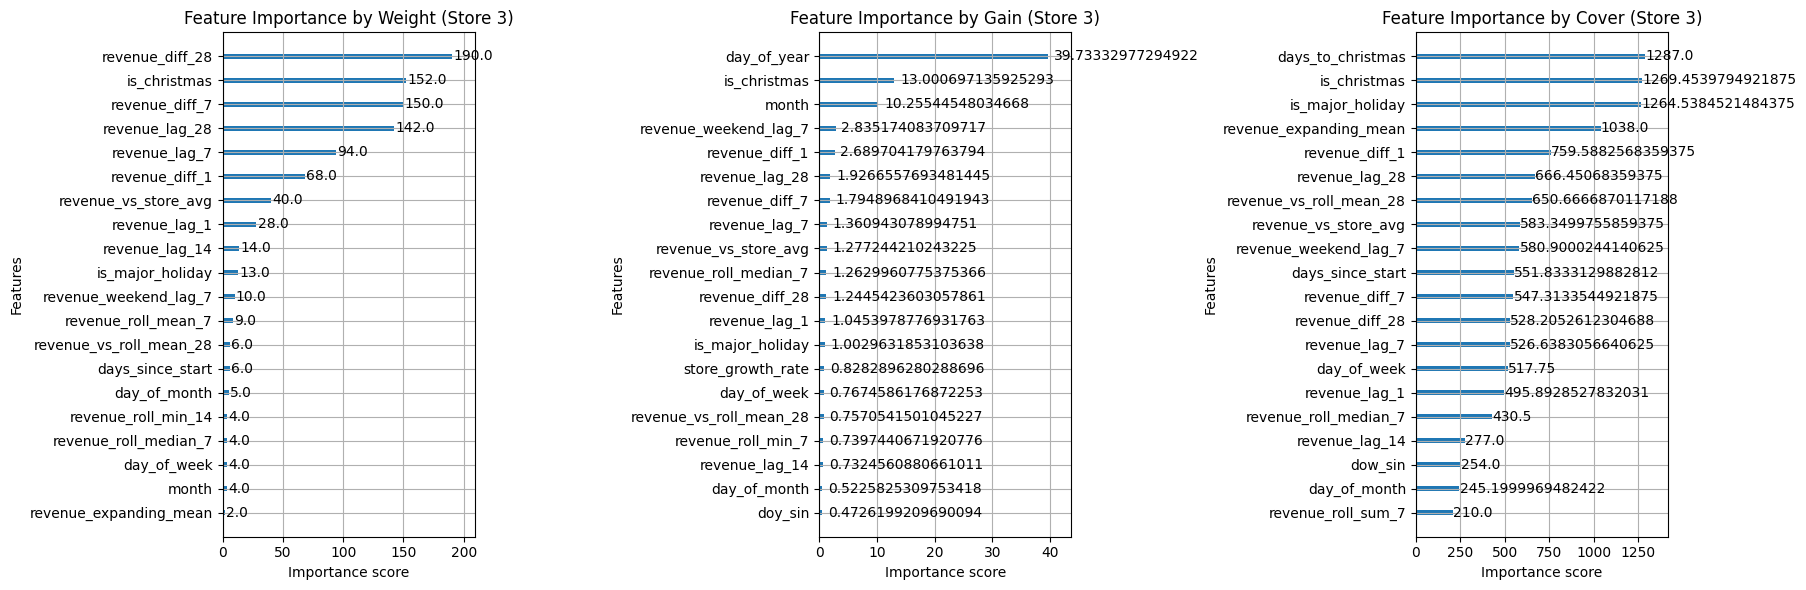


🔍 Analyzing Feature Importance for Store 3...


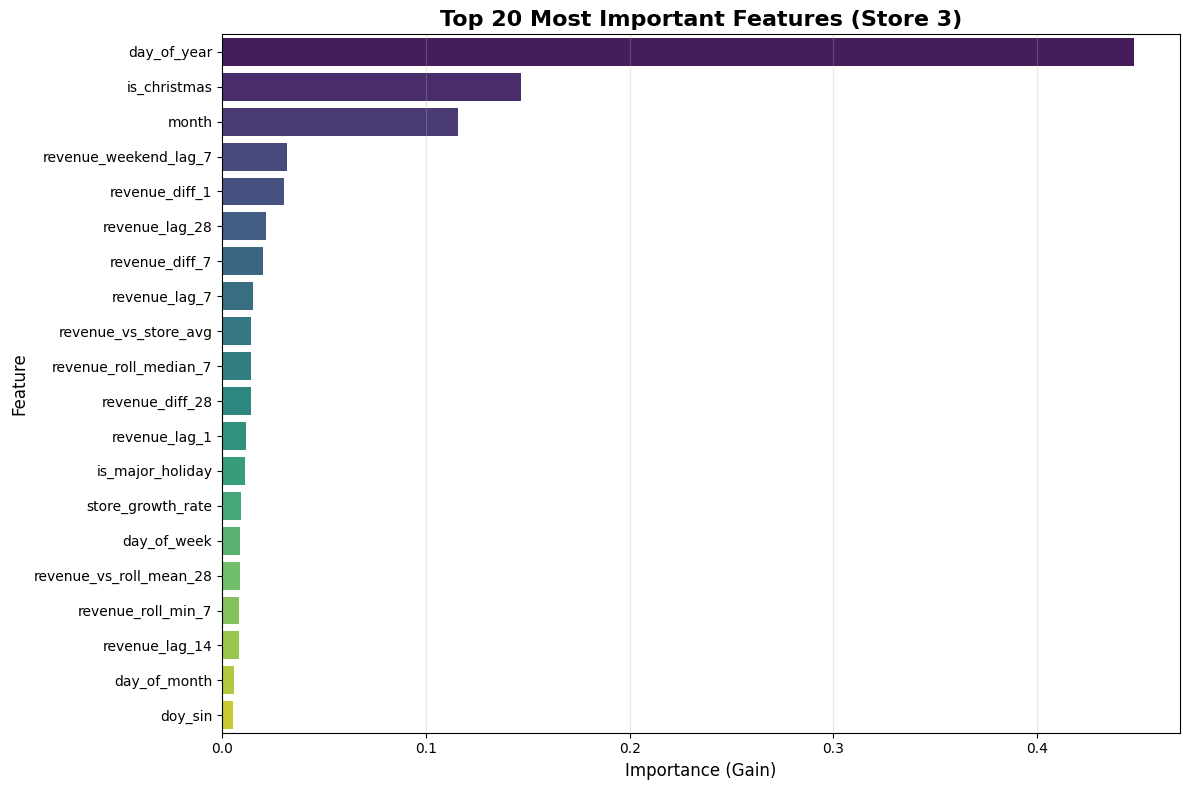


Top 20 Features:
                feature  importance
            day_of_year    0.447820
           is_christmas    0.146526
                  month    0.115585
  revenue_weekend_lag_7    0.031954
         revenue_diff_1    0.030315
         revenue_lag_28    0.021715
         revenue_diff_7    0.020230
          revenue_lag_7    0.015339
   revenue_vs_store_avg    0.014395
  revenue_roll_median_7    0.014235
        revenue_diff_28    0.014027
          revenue_lag_1    0.011782
       is_major_holiday    0.011304
      store_growth_rate    0.009335
            day_of_week    0.008650
revenue_vs_roll_mean_28    0.008532
     revenue_roll_min_7    0.008337
         revenue_lag_14    0.008255
           day_of_month    0.005890
                doy_sin    0.005327

📊 AGGREGATE FEATURE IMPORTANCE (ALL STORES)


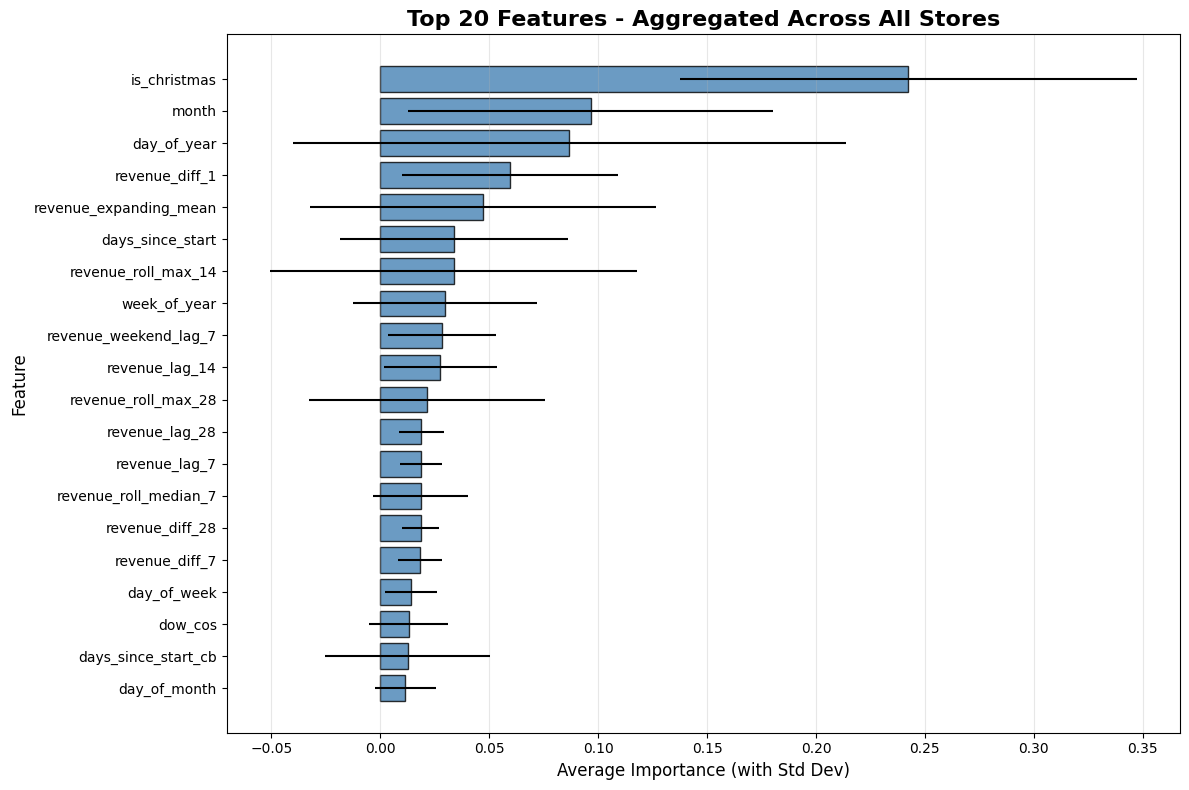


Top 20 Features (Averaged Across All Stores):
               feature  avg_importance  std_importance
          is_christmas        0.242333        0.104878
                 month        0.096557        0.083913
           day_of_year        0.086775        0.126986
        revenue_diff_1        0.059641        0.049484
revenue_expanding_mean        0.047144        0.079423
      days_since_start        0.033883        0.052511
   revenue_roll_max_14        0.033661        0.084319
          week_of_year        0.029806        0.042140
 revenue_weekend_lag_7        0.028456        0.024802
        revenue_lag_14        0.027538        0.025983
   revenue_roll_max_28        0.021526        0.054300
        revenue_lag_28        0.018817        0.010372
         revenue_lag_7        0.018667        0.009558
 revenue_roll_median_7        0.018523        0.021669
       revenue_diff_28        0.018496        0.008432
        revenue_diff_7        0.018471        0.010110
           day_of_

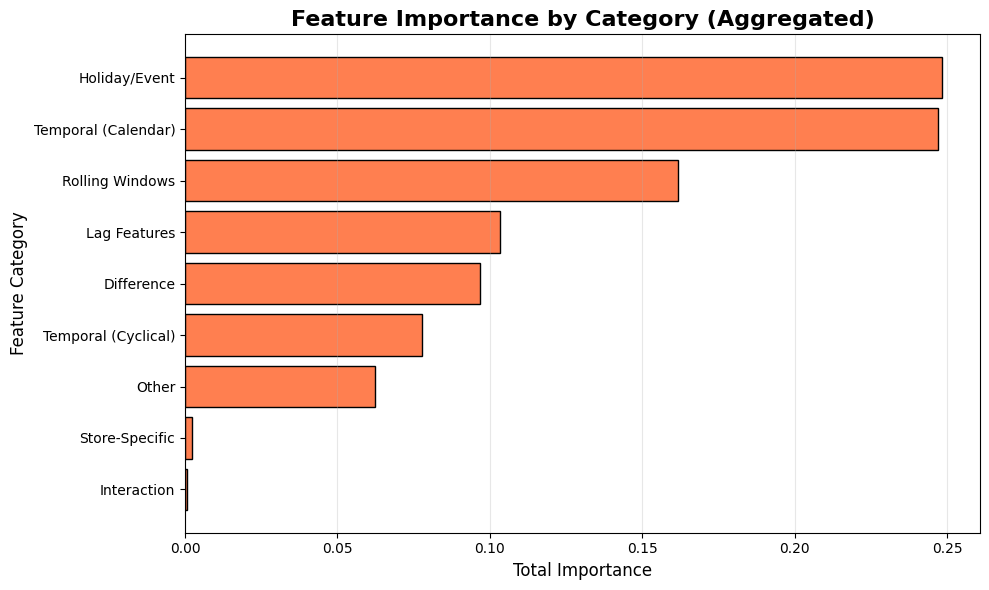


Feature Importance by Category:
  Holiday/Event            : 0.2483
  Temporal (Calendar)      : 0.2469
  Rolling Windows          : 0.1616
  Lag Features             : 0.1034
  Difference               : 0.0966
  Temporal (Cyclical)      : 0.0779
  Other                    : 0.0623
  Store-Specific           : 0.0023
  Interaction              : 0.0007

📊 FEATURE IMPORTANCE HEATMAP (TOP FEATURES ACROSS STORES)


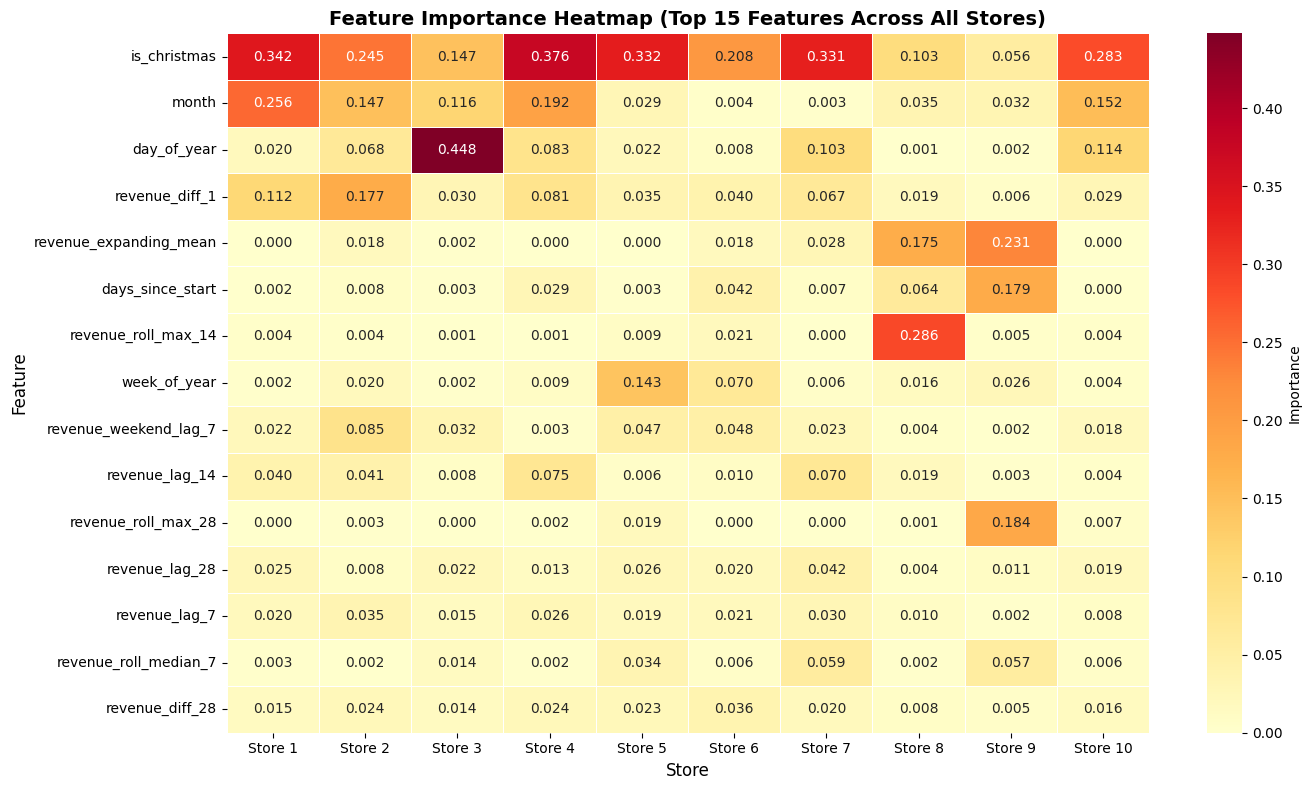


🔍 STORE-SPECIFIC FEATURE IMPORTANCE INSIGHTS

🏪 Store 1 - Top 5 Features:
   is_christmas                       : 0.3421
   month                              : 0.2558
   revenue_diff_1                     : 0.1122
   dow_cos                            : 0.0502
   revenue_lag_14                     : 0.0400

🏪 Store 2 - Top 5 Features:
   is_christmas                       : 0.2453
   revenue_diff_1                     : 0.1775
   month                              : 0.1470
   revenue_weekend_lag_7              : 0.0854
   day_of_year                        : 0.0675

🏪 Store 3 - Top 5 Features:
   day_of_year                        : 0.4478
   is_christmas                       : 0.1465
   month                              : 0.1156
   revenue_weekend_lag_7              : 0.0320
   revenue_diff_1                     : 0.0303

🏪 Store 4 - Top 5 Features:
   is_christmas                       : 0.3765
   month                              : 0.1922
   day_of_year                        :

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# =============================================================================
# METHOD 1: BUILT-IN XGBOOST FEATURE IMPORTANCE (Simplest)
# =============================================================================

print("="*70)
print("📊 XGBOOST FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Choose a store to analyze (or analyze all stores)
store_id = 3  # Store 3 (highest revenue store from EDA)

model = xgb_models[store_id]

# Plot using XGBoost's built-in function
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Importance by Weight (number of times feature is used)
xgb.plot_importance(
    model,
    importance_type='weight',
    max_num_features=20,
    ax=axes[0],
    title=f'Feature Importance by Weight (Store {store_id})'
)

# Plot 2: Importance by Gain (average gain when feature is used)
xgb.plot_importance(
    model,
    importance_type='gain',
    max_num_features=20,
    ax=axes[1],
    title=f'Feature Importance by Gain (Store {store_id})'
)

# Plot 3: Importance by Cover (coverage = number of samples affected)
xgb.plot_importance(
    model,
    importance_type='cover',
    max_num_features=20,
    ax=axes[2],
    title=f'Feature Importance by Cover (Store {store_id})'
)

plt.tight_layout()
plt.show()

# =============================================================================
# METHOD 2: CUSTOM FEATURE IMPORTANCE PLOT (More Control)
# =============================================================================

def plot_feature_importance_custom(model, feature_names, top_n=20, store_id=None):
    """
    Create a custom feature importance plot with better formatting

    Parameters:
    -----------
    model : XGBoost model
    feature_names : list of feature names
    top_n : int, number of top features to display
    store_id : int, store identifier for title
    """
    # Get feature importance (using 'gain' as it's most informative)
    importance = model.feature_importances_

    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=importance_df,
        y='feature',
        x='importance',
        palette='viridis'
    )

    title = f'Top {top_n} Most Important Features'
    if store_id is not None:
        title += f' (Store {store_id})'

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Importance (Gain)', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return importance_df

# Plot for a specific store
print(f"\n🔍 Analyzing Feature Importance for Store {store_id}...")
importance_df = plot_feature_importance_custom(
    xgb_models[store_id],
    feature_cols,
    top_n=20,
    store_id=store_id
)

print("\nTop 20 Features:")
print(importance_df.to_string(index=False))

# =============================================================================
# METHOD 3: AGGREGATE FEATURE IMPORTANCE ACROSS ALL STORES
# =============================================================================

print("\n" + "="*70)
print("📊 AGGREGATE FEATURE IMPORTANCE (ALL STORES)")
print("="*70)

def aggregate_feature_importance(models_dict, feature_names):
    """
    Calculate average feature importance across all stores

    Parameters:
    -----------
    models_dict : dict {store_id: model}
    feature_names : list of feature names

    Returns:
    --------
    DataFrame with aggregated importance
    """
    all_importances = []

    for store_id, model in models_dict.items():
        importance = model.feature_importances_
        all_importances.append(importance)

    # Average importance across all stores
    avg_importance = np.mean(all_importances, axis=0)
    std_importance = np.std(all_importances, axis=0)

    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'avg_importance': avg_importance,
        'std_importance': std_importance
    }).sort_values('avg_importance', ascending=False)

    return importance_df

# Calculate aggregate importance
aggregate_importance = aggregate_feature_importance(xgb_models, feature_cols)

# Plot top 20 features with error bars
top_features = aggregate_importance.head(20)

plt.figure(figsize=(12, 8))
plt.barh(
    range(len(top_features)),
    top_features['avg_importance'],
    xerr=top_features['std_importance'],
    alpha=0.8,
    color='steelblue',
    edgecolor='black'
)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Average Importance (with Std Dev)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Features - Aggregated Across All Stores', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 20 Features (Averaged Across All Stores):")
print(top_features[['feature', 'avg_importance', 'std_importance']].to_string(index=False))

# =============================================================================
# METHOD 4: FEATURE IMPORTANCE BY CATEGORY
# =============================================================================

print("\n" + "="*70)
print("📊 FEATURE IMPORTANCE BY CATEGORY")
print("="*70)

def categorize_features(feature_names):
    """
    Categorize features into groups
    """
    categories = {
        'Lag Features': [],
        'Rolling Windows': [],
        'Temporal (Calendar)': [],
        'Temporal (Cyclical)': [],
        'Holiday/Event': [],
        'Trend': [],
        'Store-Specific': [],
        'Interaction': [],
        'Difference': [],
        'Other': []
    }

    for feat in feature_names:
        if 'lag_' in feat:
            categories['Lag Features'].append(feat)
        elif 'roll_' in feat:
            categories['Rolling Windows'].append(feat)
        elif any(x in feat for x in ['sin', 'cos']):
            categories['Temporal (Cyclical)'].append(feat)
        elif any(x in feat for x in ['day_of_week', 'day_of_month', 'month', 'year', 'week_of_year', 'quarter', 'day_of_year', 'is_weekend', 'is_monday', 'is_friday']):
            categories['Temporal (Calendar)'].append(feat)
        elif any(x in feat for x in ['holiday', 'christmas', 'event', 'thanksgiving', 'new_year']):
            categories['Holiday/Event'].append(feat)
        elif any(x in feat for x in ['days_since_start', 'years_since']):
            categories['Trend'].append(feat)
        elif any(x in feat for x in ['store_revenue', 'store_volatility', 'store_growth']):
            categories['Store-Specific'].append(feat)
        elif 'interaction' in feat:
            categories['Interaction'].append(feat)
        elif 'diff_' in feat:
            categories['Difference'].append(feat)
        else:
            categories['Other'].append(feat)

    return categories

# Categorize features
feature_categories = categorize_features(feature_cols)

# Calculate importance by category
category_importance = {}

for category, features in feature_categories.items():
    if features:
        # Get indices of features in this category
        feature_indices = [feature_cols.index(f) for f in features]

        # Sum importance across all stores for these features
        total_importance = 0
        for model in xgb_models.values():
            total_importance += model.feature_importances_[feature_indices].sum()

        avg_importance = total_importance / len(xgb_models)
        category_importance[category] = avg_importance

# Sort by importance
category_importance = dict(sorted(category_importance.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(10, 6))
categories = list(category_importance.keys())
importances = list(category_importance.values())

plt.barh(categories, importances, color='coral', edgecolor='black')
plt.xlabel('Total Importance', fontsize=12)
plt.ylabel('Feature Category', fontsize=12)
plt.title('Feature Importance by Category (Aggregated)', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFeature Importance by Category:")
for category, importance in category_importance.items():
    print(f"  {category:25s}: {importance:.4f}")

# =============================================================================
# METHOD 5: COMPARE IMPORTANCE ACROSS STORES (Heatmap)
# =============================================================================

print("\n" + "="*70)
print("📊 FEATURE IMPORTANCE HEATMAP (TOP FEATURES ACROSS STORES)")
print("="*70)

# Get top 15 features from aggregate importance
top_15_features = aggregate_importance.head(15)['feature'].tolist()

# Create matrix: stores x features
importance_matrix = []
store_ids_list = []

for store_id in sorted(xgb_models.keys()):
    model = xgb_models[store_id]

    # Get importance for top features
    feature_indices = [feature_cols.index(f) for f in top_15_features]
    store_importance = model.feature_importances_[feature_indices]

    importance_matrix.append(store_importance)
    store_ids_list.append(f'Store {store_id}')

# Create DataFrame
importance_heatmap = pd.DataFrame(
    importance_matrix,
    index=store_ids_list,
    columns=top_15_features
)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    importance_heatmap.T,
    annot=True,
    fmt='.3f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Importance'},
    linewidths=0.5
)
plt.title('Feature Importance Heatmap (Top 15 Features Across All Stores)', fontsize=14, fontweight='bold')
plt.xlabel('Store', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# =============================================================================
# METHOD 6: IDENTIFY UNIQUE IMPORTANT FEATURES PER STORE
# =============================================================================

print("\n" + "="*70)
print("🔍 STORE-SPECIFIC FEATURE IMPORTANCE INSIGHTS")
print("="*70)

for store_id in sorted(xgb_models.keys()):
    model = xgb_models[store_id]

    # Get top 5 features for this store
    importance = model.feature_importances_
    top_5_indices = np.argsort(importance)[-5:][::-1]
    top_5_features = [feature_cols[i] for i in top_5_indices]
    top_5_importance = importance[top_5_indices]

    print(f"\n🏪 Store {store_id} - Top 5 Features:")
    for feat, imp in zip(top_5_features, top_5_importance):
        print(f"   {feat:35s}: {imp:.4f}")

print("\n" + "="*70)
print("✅ FEATURE IMPORTANCE ANALYSIS COMPLETE")
print("="*70)

### Hyperparameter Tuning -?

Hyperparameter Tuning with Optuna

# The Final Prediction Pipeline

In [ ]:
original_df['date'].max()

Timestamp('2015-09-30 00:00:00')

In [ ]:
# --- 1. SETUP & ASSUMPTIONS ---

original_df['date'] = pd.to_datetime(original_df['date'])
stores_to_forecast = list(range(1, 11))

# --- 2. PREPARE FOR FORECASTING ---
forecast_dates = pd.to_datetime(submission_ids['date'], format='%Y%m%d').unique()

# Define the global min_date required by the feature engineering function
min_date = original_df['date'].min()

# Define the feature list your models were trained on
feature_cols = [c for c in create_all_features(original_df.head(2)).columns if c not in ['revenue', 'store_name', 'date', 'event', 'store_id']]
print(f"Using {len(feature_cols)} features for prediction.")


# Initialize the history dataframe.
# It should contain original scale revenue.
# A window of 120 days is safe given lags up to 28 and rolling windows up to 91 days.
history_df = original_df.copy()
history_df['store_id'] = history_df['store_id'].astype('category') # CRITICAL for cat.codes
history_df = history_df.groupby('store_id').tail(120).reset_index(drop=True)
store_id_categories = history_df['store_id'].cat.categories

# --- 3. RECURSIVE FORECASTING LOOP ---
all_predictions = []
print(f"\nStarting recursive forecast for {len(forecast_dates)} days...")

for predict_date in tqdm(forecast_dates, desc="Forecasting"):

    # Create a placeholder for all stores for the single future date
    future_df = pd.DataFrame({
        'date': [predict_date] * len(stores_to_forecast),
        'store_id': stores_to_forecast,
        'revenue': [np.nan] * len(stores_to_forecast) # Revenue is unknown
    })
    # Ensure categorical type consistency for correct feature generation
    future_df['store_id'] = pd.Categorical(
        future_df['store_id'],
        categories=store_id_categories,
        ordered=False
    )

    # Combine history with the new day to calculate features
    combined_df = pd.concat([history_df, future_df], ignore_index=True)

    # Generate features for the combined data. The last 10 rows are our target.
    featured_df = create_all_features(combined_df)

    # Isolate the rows we just added and need to predict
    predict_data = featured_df[featured_df['date'] == predict_date].copy()

    # This list will hold the newly predicted rows to add to history
    new_history_rows = []

    # Iterate through each store to use its specific model
    for store_id in stores_to_forecast:

        # Get the specific row for this store
        row_to_predict = predict_data[predict_data['store_id'] == store_id]

        # Prepare feature set X
        X_predict = row_to_predict[feature_cols].fillna(0)

        # Predict using the correct model for the store
        model = xgb_models[store_id]
        log_prediction = model.predict(X_predict)[0]

        # Inverse transform the prediction to get actual revenue
        revenue_prediction = max(0, np.expm1(log_prediction))

        # Store prediction for the final submission file
        all_predictions.append({
            'date': predict_date,
            'store_id': store_id,
            'prediction': revenue_prediction
        })

        # Store the new row for the history update.
        # IMPORTANT: 'revenue' must be in the original scale, as create_all_features
        # will re-apply log1p in the next iteration.
        new_history_rows.append({
            'date': predict_date,
            'store_id': store_id,
            'revenue': revenue_prediction # Use original scale revenue
        })

    # CRITICAL: Update history for the next loop iteration
    history_df = pd.concat([history_df, pd.DataFrame(new_history_rows)], ignore_index=True)
    # Trim the history to keep the loop fast
    history_df = history_df.groupby('store_id').tail(120).reset_index(drop=True)

    history_df['store_id'] = pd.Categorical(
        history_df['store_id'],
        categories=store_id_categories,
        ordered=False
    )

print("Recursive forecast complete.")

# --- 4. FORMAT FOR SUBMISSION ---
print("Formatting final submission file...")

# Convert predictions list to a DataFrame
predictions_df = pd.DataFrame(all_predictions)

# Calculate total revenue (store_id = 0) by summing individual store predictions
total_revenue_df = predictions_df.groupby('date')['prediction'].sum().reset_index()
total_revenue_df['store_id'] = 0

# Combine individual and aggregate predictions
final_predictions = pd.concat([predictions_df, total_revenue_df], ignore_index=True)

# Create the 'id' column for mapping
final_predictions['date_str'] = final_predictions['date'].dt.strftime('%Y%m%d')
final_predictions['id'] = final_predictions['store_id'].astype(str) + '_' + final_predictions['date_str']

# Use .map() to securely update the sample submission file, preserving order
prediction_map = final_predictions.set_index('id')['prediction']
sample_submission['prediction'] = sample_submission['id'].map(prediction_map)

# Final check for any missing values
if sample_submission['prediction'].isnull().any():
    print(f"\nWARNING: {sample_submission['prediction'].isnull().sum()} missing predictions detected. Filling with 0.")
    sample_submission['prediction'] = sample_submission['prediction'].fillna(0)
else:
    print("\nSUCCESS! All predictions generated and mapped correctly.")

# --- 5. FINAL OUTPUT ---
print("\nPrediction Pipeline Complete.")
print("First 5 rows of the updated submission file:")
print(sample_submission.head())

# Save the final submission file
# sample_submission.to_csv('submission_final.csv', index=False)

Using 82 features for prediction.

Starting recursive forecast for 92 days...


Forecasting: 100%|██████████| 92/92 [00:20<00:00,  4.39it/s]


Recursive forecast complete.
Formatting final submission file...

SUCCESS! All predictions generated and mapped correctly.

Prediction Pipeline Complete.
First 5 rows of the updated submission file:
           id    prediction
0  0_20151001  246650.87500
1  0_20151002  260906.96875
2  0_20151003  304454.15625
3  0_20151004  301685.59375
4  0_20151005  268407.62500


In [ ]:
output_folder = PROJECT_PATH + 'submission_data/'
sample_submission.to_csv( output_folder+ 'submission_df.csv', index=False)